In [1]:
# Setup: Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import os
import re

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Data Loading
file_path = "data/steam_description_data.csv"

# If file not found in data/, try current directory
if not os.path.exists(file_path):
    file_path = "steam_description_data.csv"
    if not os.path.exists(file_path):
        raise FileNotFoundError(
            "steam_description_data.csv not found in 'data/' folder or current directory. "
            "Please ensure the file exists."
        )

try:
    df = pd.read_csv(file_path, encoding="utf-8")
except UnicodeDecodeError:
    try:
        df = pd.read_csv(file_path, encoding="latin1")
    except Exception as e:
        raise RuntimeError(f"Failed to read CSV file: {e}")

print("File loaded successfully")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
display(df.head())


File loaded successfully
Dataset shape: (27334, 4)
Columns: ['steam_appid', 'detailed_description', 'about_the_game', 'short_description']


,steam_appid,detailed_description,about_the_game,short_description
0,10,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...
3,40,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...
4,50,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...


In [3]:
# Preprocessing

# Check if 'short_description' column exists
if "short_description" not in df.columns:
    raise KeyError("Column 'short_description' not found in the dataset. Available columns: " + str(list(df.columns)))

# Drop rows where short_description is NaN
initial_count = len(df)
df = df.dropna(subset=["short_description"])
dropped_count = initial_count - len(df)
print(f"Dropped {dropped_count} rows with NaN in 'short_description'")
print(f"Remaining rows: {len(df)}")


def clean_text(text):
    """Clean text: lowercase and remove punctuation."""
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation using regex
    text = re.sub(r"[^\w\s]", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text


# Apply cleaning to short_description
df["short_description_clean"] = df["short_description"].apply(clean_text)
print("\nText cleaning completed!")
display(df[["short_description", "short_description_clean"]].head())


Dropped 0 rows with NaN in 'short_description'
Remaining rows: 27334

Text cleaning completed!


,short_description,short_description_clean
0,Play the world's number 1 online action game. ...,play the worlds number 1 online action game en...
1,One of the most popular online action games of...,one of the most popular online action games of...
2,Enlist in an intense brand of Axis vs. Allied ...,enlist in an intense brand of axis vs allied t...
3,Enjoy fast-paced multiplayer gaming with Death...,enjoy fastpaced multiplayer gaming with deathm...
4,Return to the Black Mesa Research Facility as ...,return to the black mesa research facility as ...


In [4]:
# Sentiment Analysis

def calculate_sentiment(text):
    """Calculate sentiment polarity using TextBlob."""
    if not isinstance(text, str) or not text.strip():
        return 0.0
    try:
        return float(TextBlob(text).sentiment.polarity)
    except Exception:
        return 0.0


# Calculate sentiment score
df["sentiment_score"] = df["short_description"].apply(calculate_sentiment)

# Create sentiment category
def categorize_sentiment(score):
    """Categorize sentiment: Positive if > 0, Negative if < 0, Neutral if 0."""
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"


df["sentiment_category"] = df["sentiment_score"].apply(categorize_sentiment)

print("Sentiment analysis completed!")
print(f"\nSentiment distribution:")
print(df["sentiment_category"].value_counts())
display(df[["short_description", "sentiment_score", "sentiment_category"]].head())


Sentiment analysis completed!

Sentiment distribution:
Positive    14945
Negative     9829
Neutral      2560
Name: sentiment_category, dtype: int64


,short_description,sentiment_score,sentiment_category
0,Play the world's number 1 online action game. ...,0.095833,Positive
1,One of the most popular online action games of...,0.245238,Positive
2,Enlist in an intense brand of Axis vs. Allied ...,0.095833,Positive
3,Enjoy fast-paced multiplayer gaming with Death...,0.283333,Positive
4,Return to the Black Mesa Research Facility as ...,-0.076921,Negative


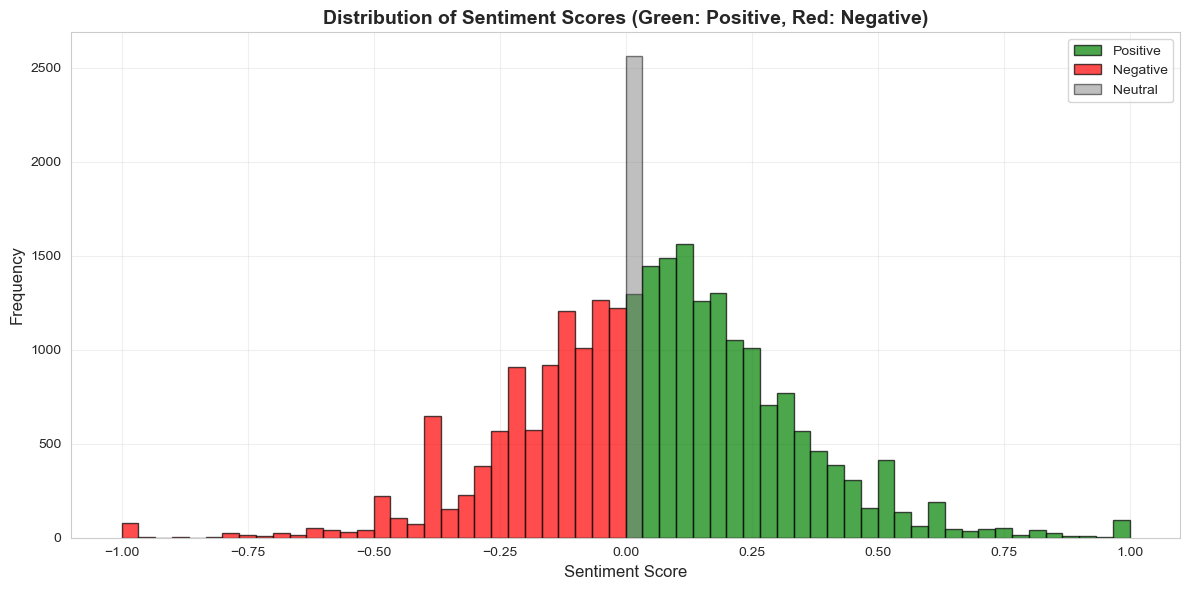

In [5]:
# Visualization

# Set seaborn style
sns.set_style("whitegrid")

# Chart 1: Colored Histogram of sentiment_score
plt.figure(figsize=(12, 6))
# Separate positive and negative scores for coloring
positive_scores = df[df["sentiment_score"] > 0]["sentiment_score"]
negative_scores = df[df["sentiment_score"] < 0]["sentiment_score"]
neutral_scores = df[df["sentiment_score"] == 0]["sentiment_score"]

# Plot histogram with colors
plt.hist(positive_scores, bins=30, color="green", alpha=0.7, label="Positive", edgecolor="black")
plt.hist(negative_scores, bins=30, color="red", alpha=0.7, label="Negative", edgecolor="black")
if len(neutral_scores) > 0:
    plt.hist(neutral_scores, bins=30, color="gray", alpha=0.5, label="Neutral", edgecolor="black")

plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Sentiment Scores (Green: Positive, Red: Negative)", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


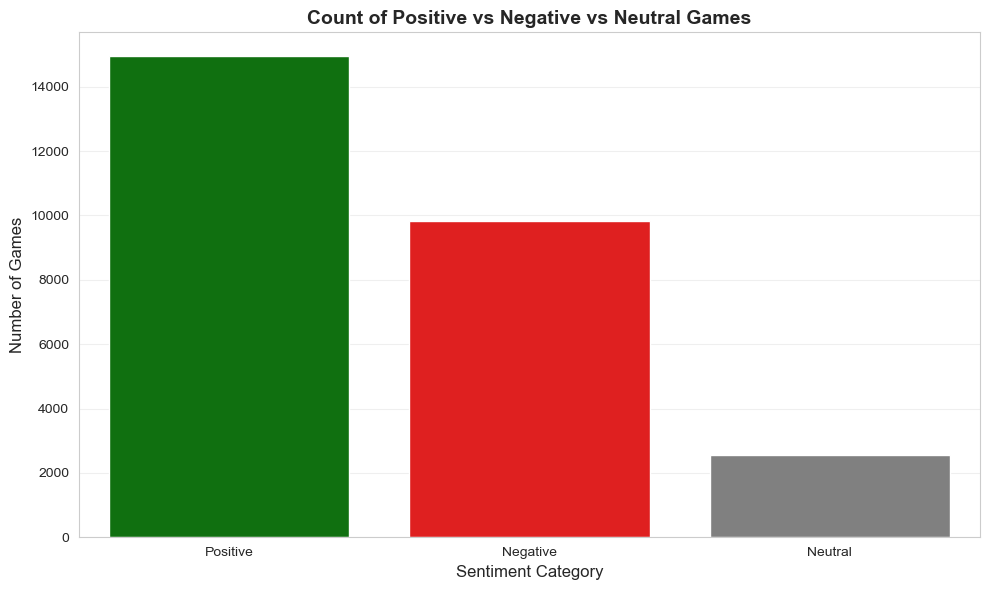

Sentiment counts:
Positive    14945
Negative     9829
Neutral      2560
Name: sentiment_category, dtype: int64


In [6]:
# Chart 2: Bar Chart showing count of Positive vs Negative vs Neutral games
sentiment_counts = df["sentiment_category"].value_counts()
plt.figure(figsize=(10, 6))

# Create bar chart with custom colors
colors = {"Positive": "green", "Negative": "red", "Neutral": "gray"}
bar_colors = [colors.get(cat, "blue") for cat in sentiment_counts.index]

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=bar_colors)
plt.xlabel("Sentiment Category", fontsize=12)
plt.ylabel("Number of Games", fontsize=12)
plt.title("Count of Positive vs Negative vs Neutral Games", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

print("Sentiment counts:")
print(sentiment_counts)


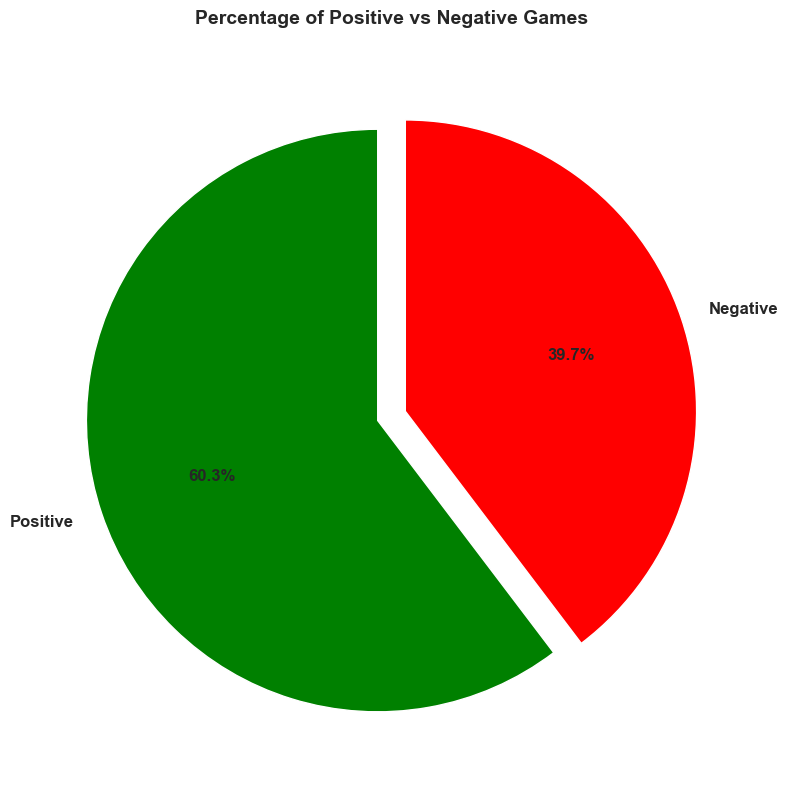


Percentage breakdown:
Positive: 60.3%
Negative: 39.7%


In [7]:
# Chart 3: Pie Chart showing percentage of Positive vs Negative games
# Filter only Positive and Negative (exclude Neutral for this chart)
pie_data = df[df["sentiment_category"].isin(["Positive", "Negative"])]["sentiment_category"].value_counts()

plt.figure(figsize=(10, 8))
colors_pie = ["green", "red"]
plt.pie(
    pie_data.values,
    labels=pie_data.index,
    autopct="%1.1f%%",
    colors=colors_pie,
    startangle=90,
    textprops={"fontsize": 12, "fontweight": "bold"},
    explode=(0.05, 0.05)  # Slight separation
)
plt.title("Percentage of Positive vs Negative Games", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()

print("\nPercentage breakdown:")
for category, count in pie_data.items():
    percentage = (count / pie_data.sum()) * 100
    print(f"{category}: {percentage:.1f}%")


In [8]:
# Tables: Top 5 Most Positive Games

# Check if 'name' column exists, otherwise use index or first column
name_col = None
if "name" in df.columns:
    name_col = "name"
elif "app_name" in df.columns:
    name_col = "app_name"
elif "title" in df.columns:
    name_col = "title"
else:
    # Use first non-numeric column as name
    for col in df.columns:
        if df[col].dtype == "object" and col != "short_description" and col != "short_description_clean":
            name_col = col
            break
    if name_col is None:
        name_col = df.columns[0]

# Get top 5 most positive games
top_positive = df.nlargest(5, "sentiment_score")[[name_col, "short_description", "sentiment_score"]].copy()
top_positive = top_positive.reset_index(drop=True)
top_positive.columns = ["name", "short_description", "score"]

print("=" * 80)
print("TOP 5 MOST POSITIVE GAMES")
print("=" * 80)
display(top_positive)


TOP 5 MOST POSITIVE GAMES


,name,short_description,score
0,"Once the Roman Empire is under your command, d...",Control and conquer the greatest empire ever k...,1.0
1,Experience the 2003 season of the FIA GT Champ...,Experience the 2003 season of the FIA GT Champ...,1.0
2,"Rendered in rich detail, four of the world’s g...",Manage transportation for commuters in four of...,1.0
3,Years after the confinement of Azhi Dahaka by ...,"As the legendary Persian hero, fight your way ...",1.0
4,In <strong>The Lord of the Rings Online™</stro...,Join the world’s greatest fellowship of player...,1.0


In [9]:
# Tables: Top 5 Most Negative Games

# Get top 5 most negative games (smallest sentiment scores)
top_negative = df.nsmallest(5, "sentiment_score")[[name_col, "short_description", "sentiment_score"]].copy()
top_negative = top_negative.reset_index(drop=True)
top_negative.columns = ["name", "short_description", "score"]

print("=" * 80)
print("TOP 5 MOST NEGATIVE GAMES")
print("=" * 80)
display(top_negative)


TOP 5 MOST NEGATIVE GAMES


,name,short_description,score
0,<p>Awarded “Top 10 Game of 2004” by Computer G...,"Even as the world erupts in civil war, an anci...",-1.0
1,<h1>Full Controller Support</h1><p>Free update...,Assume the role of the daring demolition worke...,-1.0
2,Join The Mobile Trench Brigade and protect hum...,Join The Mobile Trench Brigade and protect hum...,-1.0
3,"<h1>Buzz</h1><p><a href=""http://store.steampow...",Experience the Fear: Set in the terrifying wor...,-1.0
4,The Paranormal Research team from the hit A&am...,Thrills abound as the ghost-hunters from the h...,-1.0
